# EDA


## Library Imports

In [622]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

import time

## Data Imports

In [367]:
#train data
data = pd.read_csv('../raw_data/dengue_features_train.csv')
labels = pd.read_csv('../raw_data/dengue_labels_train.csv')
data = data.merge(labels)
print(data.shape)

#test data
test_data = pd.read_csv('../raw_data/dengue_features_test.csv')
print(test_data.shape)

(1456, 25)
(416, 24)


In [368]:
data

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,iq,2010,21,2010-05-28,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,...,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0,5
1452,iq,2010,22,2010-06-04,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,...,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6,8
1453,iq,2010,23,2010-06-11,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,...,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4,1
1454,iq,2010,24,2010-06-18,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,...,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0,1


## Functions

In [619]:
def reg_metrics(y_train, y_train_pred, y_test, y_test_pred, model='model'):
    test_mae = metrics.mean_absolute_error(y_test, y_test_pred, multioutput='raw_values')
    train_mae = metrics.mean_absolute_error(y_train, y_train_pred, multioutput='raw_values')
    metrics_df = pd.DataFrame(data = zip(test_mae, train_mae),
                              columns=['test_mae','train_mae'])
    metrics_df.index.names = [model]
    return metrics_df

## Basic data preparation and visualizations

In [370]:
#NaN count for each column
data.isnull().sum().sort_values(ascending=False)

ndvi_ne                                  194
ndvi_nw                                   52
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
station_precip_mm                         22
ndvi_se                                   22
ndvi_sw                                   22
station_max_temp_c                        20
station_min_temp_c                        14
precipitation_amt_mm                      13
reanalysis_sat_precip_amt_mm              13
reanalysis_relative_humidity_percent      10
reanalysis_tdtr_k                         10
reanalysis_specific_humidity_g_per_kg     10
reanalysis_max_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_min_air_temp_k                 10
reanalysis_dew_point_temp_k               10
reanalysis_air_temp_k                     10
reanalysis_avg_temp_k                     10
city                                       0
year                                       0
week_start

These Nan values will be tackled in preprocessing

### Splitting data into separate dataframes for both cities

In [371]:
data_sj = data.iloc[:936,:]

In [372]:
data_iq = data.iloc[936:,:]

In [373]:
print(data_iq.shape,data_sj.shape)

(520, 25) (936, 25)


In [374]:
#fix time data
data_iq['year_week'] = pd.to_datetime(data_iq['week_start_date']).dt.strftime('%Y-%U')
data_iq['week'] = pd.to_datetime(data_iq['week_start_date']).dt.strftime('%U')
data_iq['month'] = pd.DatetimeIndex(data_iq['week_start_date']).month

data_sj['year_week'] = pd.to_datetime(data_sj['week_start_date']).dt.strftime('%Y-%U')
data_sj['week'] = pd.to_datetime(data_sj['week_start_date']).dt.strftime('%U')
data_sj['month'] = pd.DatetimeIndex(data_sj['week_start_date']).month

/var/folders/32/ctcz3rj15jg1r9xjzn1p08p40000gn/T/ipykernel_94107/611139066.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_iq['year_week'] = pd.to_datetime(data_iq['week_start_date']).dt.strftime('%Y-%U')
/var/folders/32/ctcz3rj15jg1r9xjzn1p08p40000gn/T/ipykernel_94107/611139066.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_iq['week'] = pd.to_datetime(data_iq['week_start_date']).dt.strftime('%U')
/var/folders/32/ctcz3rj15jg1r9xjzn1p08p40000gn/T/ipykernel_94107/611139066.py:4: SettingWith

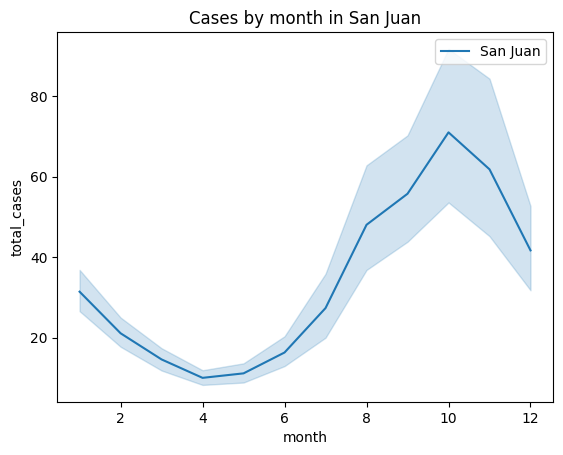

In [620]:
plt.title('Cases by month in San Juan')
sns.lineplot(data=data_sj,x='month',y='total_cases',label='San Juan')
plt.show;

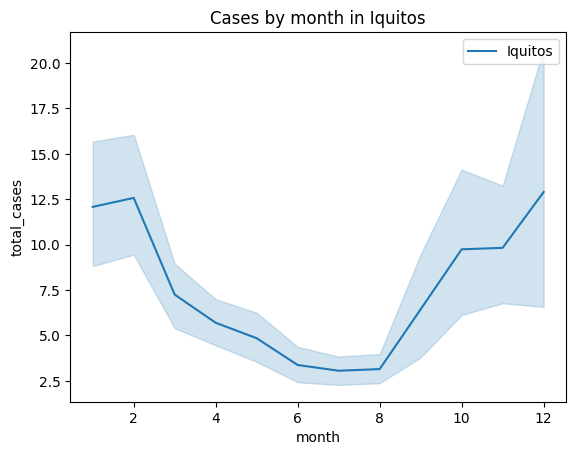

In [621]:
plt.title('Cases by month in Iquitos')
sns.lineplot(data=data_iq,x='month',y='total_cases',label='Iquitos')
plt.show;

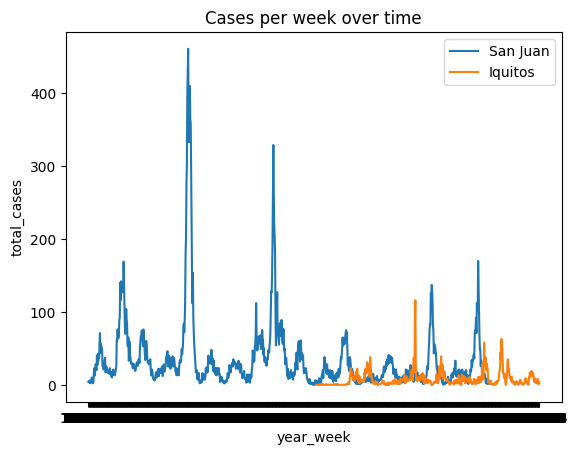

In [379]:
plt.title('Cases per week over time')
sns.lineplot(data=sj_data,x='year_week',y='total_cases',label='San Juan')
sns.lineplot(data=iq_data,x='year_week',y='total_cases',label='Iquitos')
plt.legend()
plt.show;

## Preprocessing San Juan

In [538]:
def preprocess_sj(rawfeats,train=True):
    
    #fill nas with interpolation
    feats = rawfeats.interpolate(method='linear')
    
    #scale the average temperature readings 
    tempscols_to_average = feats.loc[:,['reanalysis_max_air_temp_k', 'station_avg_temp_c',
       'reanalysis_avg_temp_k', 'reanalysis_min_air_temp_k',
       'station_min_temp_c', 'reanalysis_dew_point_temp_k',
       'reanalysis_air_temp_k']]
    scaled_temps = pd.DataFrame(MinMaxScaler().fit_transform(tempscols_to_average), 
                            columns=tempscols_to_average.columns)
    feats.loc[:,'temps_mean'] = scaled_temps.mean(axis=1)
    
    #add shifted features, 3 weeks
    to_shift = ['station_max_temp_c', 'temps_mean','reanalysis_relative_humidity_percent',
       'reanalysis_specific_humidity_g_per_kg','reanalysis_precip_amt_kg_per_m2'] 
    for i in to_shift:
        feats[i+'_1lag'] = feats[i].shift(-1)
        feats[i+'_2lag'] = feats[i].shift(-2)
        feats[i+'_3lag'] = feats[i].shift(-3)
    feats = feats.fillna(method='ffill')
    
    #drop columns
    if train:
        feats.drop(columns=['reanalysis_max_air_temp_k', 'station_avg_temp_c',
           'reanalysis_avg_temp_k', 'reanalysis_min_air_temp_k',
           'station_min_temp_c', 'reanalysis_dew_point_temp_k',
           'reanalysis_air_temp_k','city','week_start_date','weekofyear','year','year_week','week','month'], axis=1, inplace=True)
    else:
        feats.drop(columns=['reanalysis_max_air_temp_k', 'station_avg_temp_c',
           'reanalysis_avg_temp_k', 'reanalysis_min_air_temp_k',
           'station_min_temp_c', 'reanalysis_dew_point_temp_k',
           'reanalysis_air_temp_k','city','week_start_date','weekofyear','year'], axis=1, inplace=True)
    
    return feats

In [386]:
sj_data = preprocess_sj(data_sj)

In [387]:
sj_data

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,...,temps_mean_3lag,reanalysis_relative_humidity_percent_1lag,reanalysis_relative_humidity_percent_2lag,reanalysis_relative_humidity_percent_3lag,reanalysis_specific_humidity_g_per_kg_1lag,reanalysis_specific_humidity_g_per_kg_2lag,reanalysis_specific_humidity_g_per_kg_3lag,reanalysis_precip_amt_kg_per_m2_1lag,reanalysis_precip_amt_kg_per_m2_2lag,reanalysis_precip_amt_kg_per_m2_3lag
0,0.122600,0.103725,0.198483,0.177617,12.42,32.00,73.365714,12.42,14.012857,2.628571,...,0.599826,77.368571,82.052857,80.337143,15.372857,16.848571,16.672857,17.94,26.10,13.90
1,0.169900,0.142175,0.162357,0.155486,22.82,17.94,77.368571,22.82,15.372857,2.371429,...,0.692043,82.052857,80.337143,80.460000,16.848571,16.672857,17.210000,26.10,13.90,12.20
2,0.032250,0.172967,0.157200,0.170843,34.54,26.10,82.052857,34.54,16.848571,2.300000,...,0.703828,80.337143,80.460000,79.891429,16.672857,17.210000,17.212857,13.90,12.20,26.49
3,0.128633,0.245067,0.227557,0.235886,15.36,13.90,80.337143,15.36,16.672857,2.428571,...,0.624785,80.460000,79.891429,82.000000,17.210000,17.212857,17.234286,12.20,26.49,38.60
4,0.196200,0.262200,0.251200,0.247340,7.52,12.20,80.460000,7.52,17.210000,3.014286,...,0.660543,79.891429,82.000000,83.375714,17.212857,17.234286,17.977143,26.49,38.60,30.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,0.077850,-0.039900,0.310471,0.296243,27.19,7.55,74.247143,27.19,13.644286,2.885714,...,0.350606,74.600000,75.027143,72.285714,14.662857,14.184286,13.858571,3.67,35.00,4.82
932,-0.038000,-0.016833,0.119371,0.066386,3.82,3.67,74.600000,3.82,14.662857,2.714286,...,0.520972,75.027143,72.285714,76.960000,14.184286,13.858571,15.671429,35.00,4.82,2.17
933,-0.155200,-0.052750,0.137757,0.141214,16.96,35.00,75.027143,16.96,14.184286,2.185714,...,0.520972,72.285714,76.960000,76.960000,13.858571,15.671429,15.671429,4.82,2.17,2.17
934,0.001800,-0.031558,0.203900,0.209843,0.00,4.82,72.285714,0.00,13.858571,2.785714,...,0.520972,76.960000,76.960000,76.960000,15.671429,15.671429,15.671429,2.17,2.17,2.17


## Preprocessing Iquitos

In [524]:
def preprocess_iq(rawfeats,train=True):
    
    #fill nas with interpolation
    feats = rawfeats.interpolate(method='linear')
    
    #add shifted features, 3 weeks
    to_shift = ['station_max_temp_c','reanalysis_relative_humidity_percent',
       'reanalysis_specific_humidity_g_per_kg','reanalysis_precip_amt_kg_per_m2'] 
    for i in to_shift:
        feats[i+'_1lag'] = feats[i].shift(-1)
        feats[i+'_2lag'] = feats[i].shift(-2)
        feats[i+'_3lag'] = feats[i].shift(-3)
    feats = feats.fillna(method='ffill')
    
    #drop columns
    if train:
        feats.drop(columns=['city','week_start_date','weekofyear','year','year_week','week','month'], axis=1, inplace=True)
    else:
        feats.drop(columns=['city','week_start_date','weekofyear','year'], axis=1, inplace=True)
    return feats

In [389]:
iq_data = preprocess_iq(data_iq)

In [390]:
iq_data

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,...,station_max_temp_c_3lag,reanalysis_relative_humidity_percent_1lag,reanalysis_relative_humidity_percent_2lag,reanalysis_relative_humidity_percent_3lag,reanalysis_specific_humidity_g_per_kg_1lag,reanalysis_specific_humidity_g_per_kg_2lag,reanalysis_specific_humidity_g_per_kg_3lag,reanalysis_precip_amt_kg_per_m2_1lag,reanalysis_precip_amt_kg_per_m2_2lag,reanalysis_precip_amt_kg_per_m2_3lag
936,0.192886,0.132257,0.340886,0.247200,25.41,296.740000,298.450000,295.184286,307.3,293.1,...,31.5,93.581429,95.848571,87.234286,16.862857,17.120000,14.431429,46.00,64.77,23.96
937,0.216833,0.276100,0.289457,0.241657,60.61,296.634286,298.428571,295.358571,306.6,291.1,...,33.3,95.848571,87.234286,88.161429,17.120000,14.431429,15.444286,64.77,23.96,31.80
938,0.176757,0.173129,0.204114,0.128014,55.52,296.415714,297.392857,295.622857,304.5,292.6,...,32.0,87.234286,88.161429,74.728571,14.431429,15.444286,13.421429,23.96,31.80,1.00
939,0.227729,0.145429,0.254200,0.200314,5.60,295.357143,296.228571,292.797143,303.6,288.6,...,34.0,88.161429,74.728571,83.275714,15.444286,13.421429,15.311429,31.80,1.00,26.68
940,0.328643,0.322129,0.254371,0.361043,62.76,296.432857,297.635714,293.957143,307.0,291.5,...,33.0,74.728571,83.275714,82.490000,13.421429,15.311429,15.465714,1.00,26.68,16.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,300.771429,296.825714,309.7,294.5,...,31.2,91.600000,94.280000,94.660000,18.070000,17.008571,16.815714,207.10,50.60,62.33
1452,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,299.392857,296.452857,308.5,291.9,...,33.7,94.280000,94.660000,89.082857,17.008571,16.815714,17.355714,50.60,62.33,36.90
1453,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,297.592857,295.501429,305.5,292.4,...,33.7,94.660000,89.082857,89.082857,16.815714,17.355714,17.355714,62.33,36.90,36.90
1454,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,297.521429,295.324286,306.1,291.9,...,33.7,89.082857,89.082857,89.082857,17.355714,17.355714,17.355714,36.90,36.90,36.90


## A look at correlations

In [391]:
# compute the correlations
sj_correlations = sj_data.corr()
iq_correlations = iq_data.corr()

Text(0.5, 1.0, 'San Juan Variable Correlations')

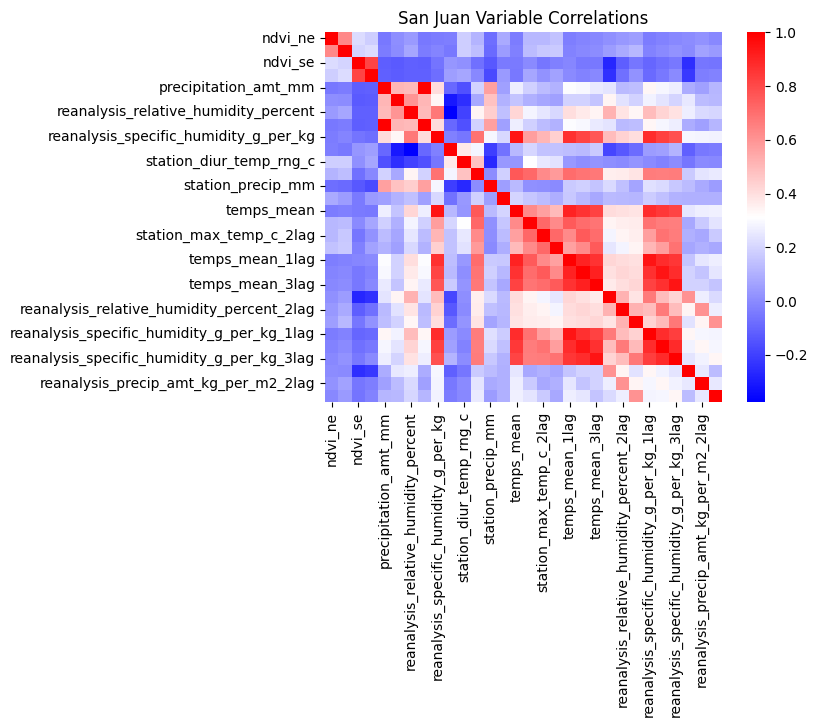

In [392]:
# plot san juan
sj_heatmap = sns.heatmap(sj_correlations,cmap= "bwr")
plt.title('San Juan Variable Correlations')

Text(0.5, 1.0, 'Iquitos Variable Correlations')

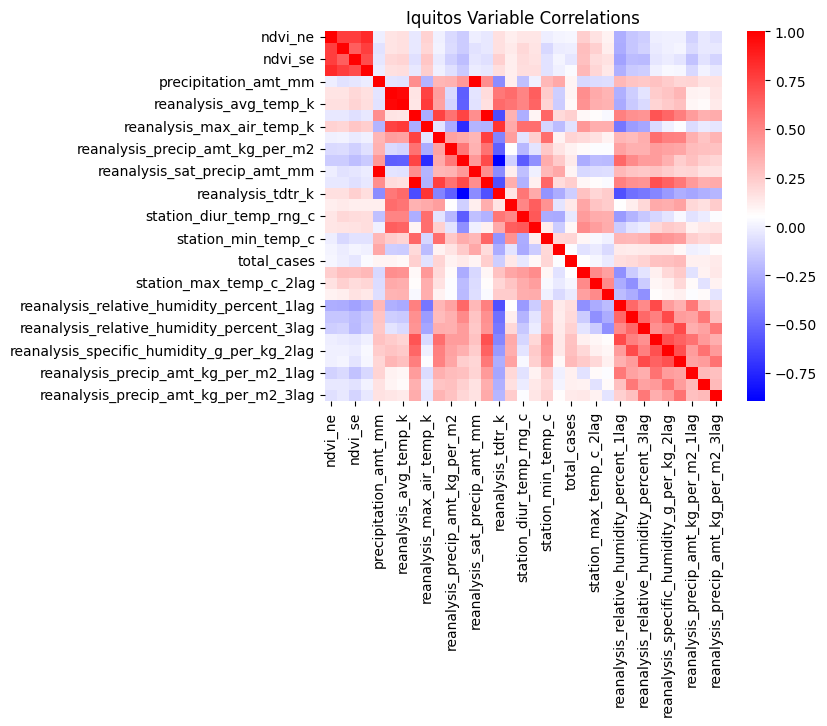

In [393]:
# plot iquitos
iq_corr_heat = sns.heatmap(iq_correlations,cmap= "bwr")
plt.title('Iquitos Variable Correlations')

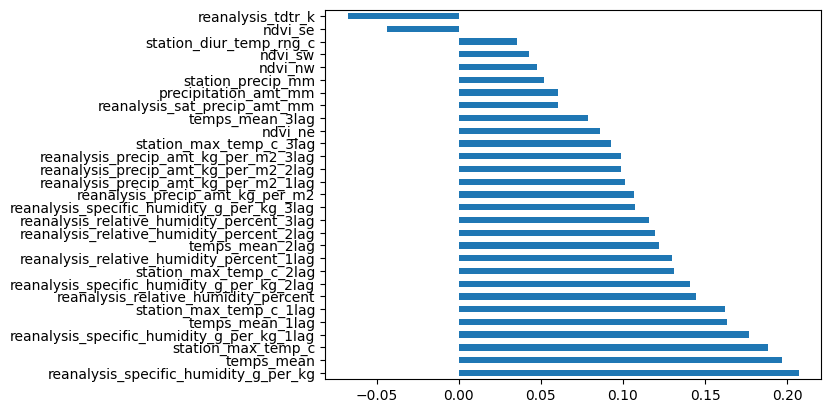

In [394]:
# San Juan
(sj_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh());

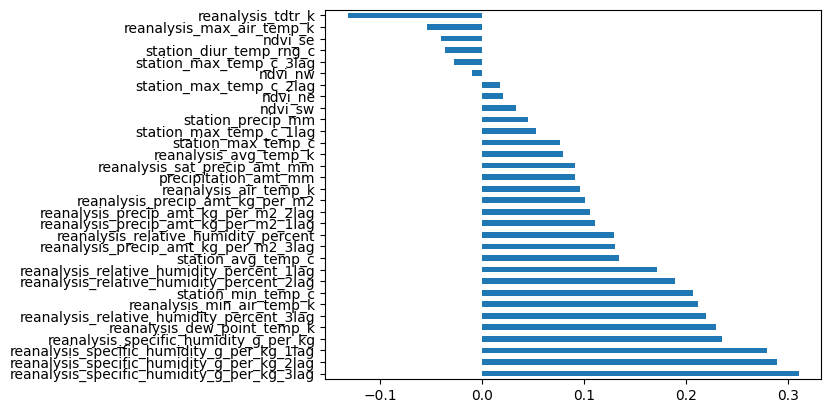

In [395]:
# Iquitos
(iq_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh());

## Modeling

In [486]:
iq_X = iq_data.drop(['total_cases'], axis=1)
iq_y = iq_data.total_cases

iq_X_train = iq_X.head(490)
iq_X_test = iq_X.tail(130)
iq_y_train = iq_y.head(490)
iq_y_test = iq_y.tail(130)

print(iq_X_train.shape)
print(iq_X_test.shape)

(490, 32)
(130, 32)


In [487]:
sj_X = sj_data.drop(['total_cases'], axis=1)
sj_y = sj_data.total_cases

sj_X_train = sj_X.head(702)
sj_X_test = sj_X.tail(234)
sj_X_train = sj_X.head(702)
sj_X_test = sj_X.tail(234)

print(sj_X_train.shape)
print(sj_X_test.shape)

(702, 29)
(234, 29)


### ADF test for stationarity

In [480]:
from statsmodels.tsa.stattools import adfuller

print('p-value: ', adfuller(data_sj["total_cases"])[1])

p-value:  5.1473186737591e-09


In [481]:
from statsmodels.tsa.stattools import adfuller

print('p-value: ', adfuller(data_iq["total_cases"])[1])

p-value:  1.0672522948401663e-07


### Random Forest

In [498]:
#Define the parameters we want to use for the Grid Search
param_grid = {
    'max_depth': [5,15,None],
    'warm_start': [True, False],
    'max_features': [2, 5],
    'min_samples_leaf': [1,5,15],
    'min_samples_split': [2, 3],
    'n_estimators': [100, 200],
}


In [500]:
#Grid Search SJ
start = time.time()

rf = RandomForestRegressor(criterion='absolute_error')
search_rf = GridSearchCV(rf, param_grid=param_grid, 
                              cv=TimeSeriesSplit(n_splits=5), n_jobs=2, verbose=2, scoring='neg_mean_absolute_error')
search_rf.fit(sj_X, sj_y);
sj_rf_params = search_rf.best_params_
print(search_rf.best_score_)

executionTime = (time.time() - start)
print("Execution time:",
      np.round(executionTime,2)," seconds")

Fitting 5 folds for each of 144 candidates, totalling 720 fits
-26.033711538461535
Execution time: 990.4440860748291


In [501]:
sj_rf_params

{'max_depth': 5,
 'max_features': 2,
 'min_samples_leaf': 15,
 'min_samples_split': 2,
 'n_estimators': 100,
 'warm_start': False}

In [502]:
#Grid Search IQ
start = time.time()

rf = RandomForestRegressor(criterion='absolute_error')
search_rf = GridSearchCV(rf, param_grid=param_grid, 
                              cv=TimeSeriesSplit(n_splits=5), n_jobs=2, verbose=2, scoring='neg_mean_absolute_error')
search_rf.fit(iq_X, iq_y);
iq_rf_params = search_rf.best_params_
print(search_rf.best_score_)

executionTime = (time.time() - start)
print("Execution time:",
      np.round(executionTime,2)," seconds")

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV] END max_depth=5, max_features=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, warm_start=True; total time=   0.3s
[CV] END max_depth=5, max_features=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, warm_start=True; total time=   0.6s
[CV] END max_depth=5, max_features=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, warm_start=False; total time=   0.2s
[CV] END max_depth=5, max_features=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, warm_start=False; total time=   0.3s
[CV] END max_depth=5, max_features=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, warm_start=False; total time=   0.4s
[CV] END max_depth=5, max_features=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, warm_start=False; total time=   1.0s
[CV] END max_depth=5, max_features=2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, warm_start=True; total time=   0.9s
[C

[CV] END max_depth=5, max_features=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, warm_start=True; total time=   0.2s
[CV] END max_depth=5, max_features=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, warm_start=True; total time=   0.4s
[CV] END max_depth=5, max_features=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, warm_start=True; total time=   0.8s
[CV] END max_depth=5, max_features=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, warm_start=False; total time=   0.6s
[CV] END max_depth=5, max_features=2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, warm_start=True; total time=   0.6s
[CV] END max_depth=5, max_features=2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, warm_start=True; total time=   0.5s
[CV] END max_depth=5, max_features=2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, warm_start=True; total time=   1.3s
[CV] END max_depth=5, max_features=2, min_samples_leaf=1, min_sample

-6.335930232558139
Execution time: 426.2807729244232


In [503]:
iq_rf_params

{'max_depth': None,
 'max_features': 5,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 100,
 'warm_start': False}

In [504]:
#Initialize models
sj_rf_model = RandomForestRegressor(**sj_rf_params, criterion='absolute_error')
iq_rf_model = RandomForestRegressor(**iq_rf_params, criterion='absolute_error')

In [505]:
#Fitting models on training data

sj_rf_model.fit(sj_X_train, sj_y_train)

iq_rf_model.fit(iq_X_train, iq_y_train)

print('Training Complete!')

Training Complete!


In [568]:
#Making predictions on training and testing data for San Juan

sj_train_pred = sj_rf_model.predict(sj_X_train).astype(int)
sj_test_pred = sj_rf_model.predict(sj_X_test).astype(int)

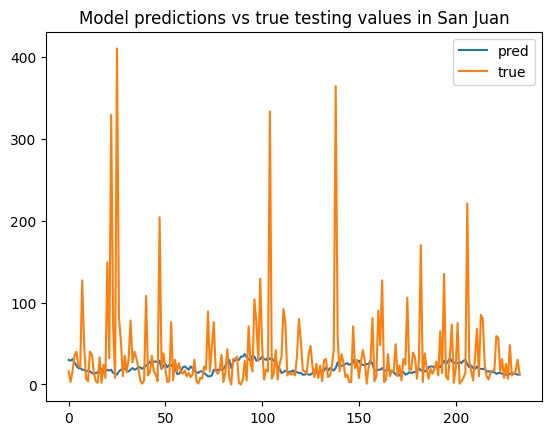

In [627]:
# plotting predictions vs testing values for San Juan
plt.plot(sj_test_pred, label='pred')
plt.plot(sj_y_test.values, label='true')
plt.legend()
plt.title('Model predictions vs true testing values in San Juan')
plt.show;

In [612]:
#Making predictions on training and testing data for Iquitos

iq_test_pred = iq_rf_model.predict(iq_X_test).astype(int)
iq_train_pred = iq_rf_model.predict(iq_X_train).astype(int)

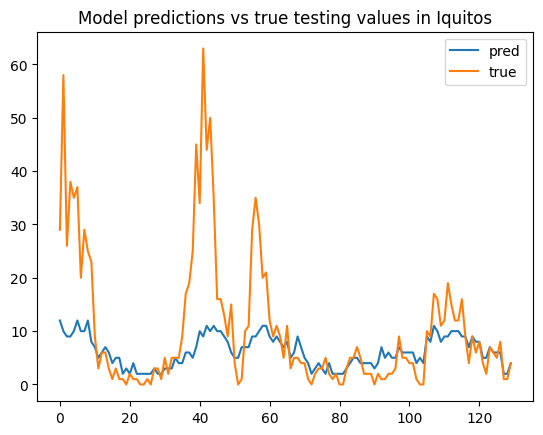

In [626]:
# plotting predictions vs testing values for Iquitos
plt.plot(iq_test_pred, label='pred')
plt.plot(iq_y_test.values, label='true')
plt.legend()
plt.title('Model predictions vs true testing values in Iquitos')
plt.show;

In [617]:
#concatenating training and testing predictions and values
iq_total_pred = np.hstack((iq_train_pred,iq_test_pred))
iq_true_values = np.hstack((iq_y_train.values,iq_y_test.values))

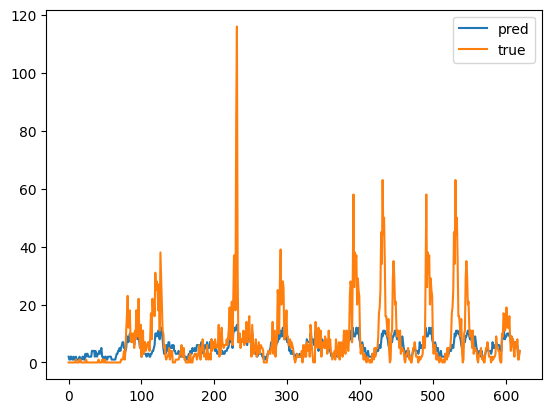

In [618]:
plt.plot(iq_total_pred, label='pred')
plt.plot(iq_true_values, label='true')
plt.plot(iq_total_pred, label='pred')
plt.plot(iq_true_values, label='true')
plt.legend()
plt.title('Model predictions vs true testing values in Iquitos')
plt.show;

In [596]:
# Get training and testing metrics
sj_rf_metrics = reg_metrics(sj_y_train, sj_train_pred, sj_y_test, sj_test_pred,'San Juan rf')

sj_rf_metrics.T

San Juan rf,0
test_mae,26.927350
train_mae,24.826211


In [ ]:
# Get training and testing metrics
iq_rf_metrics = reg_metrics(iq_y_train, sj_train_pred, sj_y_test, sj_test_pred,'San Juan rf')

sj_rf_metrics.T

## Submission prediction

In [549]:
sj_rf_model.fit(sj_X, sj_y)

iq_rf_model.fit(iq_X, iq_y)

print('Training Complete!')

Training Complete!


In [550]:
testing_data = pd.read_csv('../raw_data/dengue_features_test.csv')

In [551]:
sj_test = testing_data[testing_data.city=='sj'].copy()
sj_test = preprocess_sj(sj_test,train=False)
sj_test.shape

(260, 29)

In [552]:
iq_test = testing_data[testing_data.city=='iq'].copy()
iq_test = preprocess_iq(iq_test,train=False)
#Should be 32 feat columns
iq_test.shape

(156, 32)

In [560]:
sj_pred = sj_rf_model.predict(sj_test).astype(int)
iq_pred = iq_rf_model.predict(iq_test).astype(int)

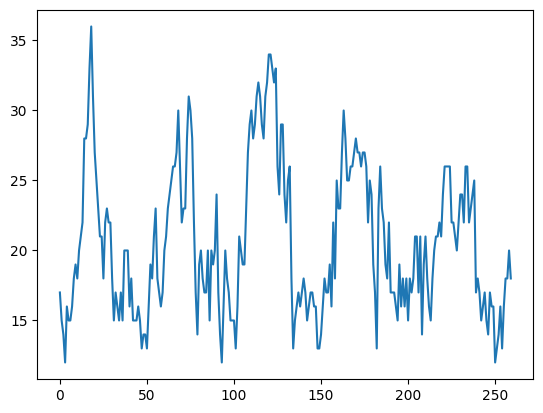

In [598]:
plt.plot(sj_pred, label='pred')
plt.show;

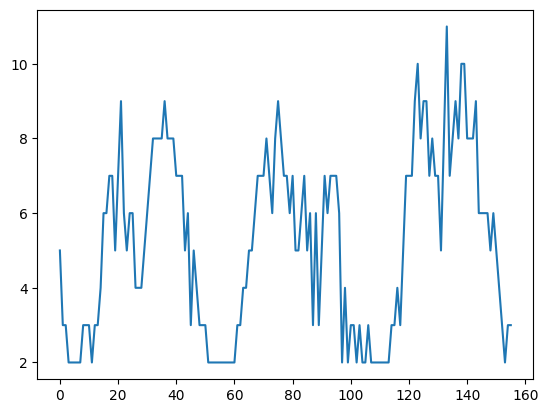

In [599]:
plt.plot(iq_pred, label='pred')
plt.show;

In [561]:
#Confirm no negative predictions
print(np.min(sj_pred))
print(np.min(iq_pred))

12
2


In [562]:
submission = pd.read_csv('../raw_data/submission_format.csv',
                            index_col=[0, 1, 2])

In [563]:
submission.total_cases = np.concatenate([sj_pred, iq_pred])
submission.to_csv("../submissions/rf_submission.csv")